# Matrix Factorization based Word Embeddings 

According to Wikipedia, **word embedding** is the collective name for a set of language modeling and feature learning techniques in natural language processing (NLP) where words or phrases from the vocabulary are mapped to vectors of real numbers.

For a predefined vocabulary of allowed words, we build up a look-up table containing the embeddings all vocabulary words. This embedding can be found using the word index in the vocabulary (i.e., you to look up the embedding in the table using word index). Using this look-up table, we can form any sentence as an input vector or matrix for the machine/deep learning models. 

Demonstration from: https://lena-voita.github.io/nlp_course/word_embeddings.html

![](https://lena-voita.github.io/resources/lectures/word_emb/lookup_table.gif)

The main topic we will explore in this lab is: **how do we get these word representations/embeddings?**



Simply, we can represent every word as an $\mathbb{R}^{|V|×1}$ vector with all 0s and one 1 at the index of that word in the vocabulary. This is so-called **one-hot** vector. As discussed in previous labs, we know that such representations are sparse and cannot capture similarity. While we would expect these word embeddings to store the meaning of the word and therefore models can learn from them to understand the abstract concepts expressing using the language.  

Considering how human interpret the meaning of words, especially get to know the similarity between words, there is 

* **the distributional hypothesis**  that the meaning of a word is the set of contexts in which it occurs in texts. 

In other words, important aspects of the meaning of a word are a function of (can be approximated by) the set of contexts in which it occurs in texts.

Motivated by the hypothesis, we construct word co-occurrent  matrix as sparse representation of context information for each word in the vocabuary and transform such matrix into the word embeddings by matrix factorization.    

Specifically, it can be summarized in two steps:

* we first loop over the corpora and accumulate word co-occurrence counts in some form of a matrix $X$, 

* and then perform matrix factorization algorithms on $X$ to get a decomposition. We then use the rows of one of the resulting matrixs as the word embeddings for all
words in the dictionary. 


<div>
<img src="https://drive.google.com/uc?export=view&id=1jWEzplTQIror4W5o7HVDEpD5sYrEIGlM" width="600"/>
</div>


* Figure is modified from https://lena-voita.github.io/nlp_course/word_embeddings.html 

In [ ]:
# env setups
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_context('talk')

import tqdm
import pandas as pd
import numpy as np

## Word Co-occurrence Matrix

We construct co-occurrence matrix between words to capture their statistical regulairities appeared in the given corpus. It counts how often each pair of words co-occur given a context window.  

Specifcically, given some word  $w_i$ occurring in the document, we consider the `context window` surrounding  $w_i$. Supposing we use a fixed window size of $m$ , then this is the $m$ preceding and $m$ subsequent words in that document, i.e. words  $w_{𝑖-m}, ..., w_{𝑖−1}$  and $w_{𝑖+1}, ..., w_{𝑖+m}$. We build a co-occurrence matrix $X$ , which is a symmetric word-by-word matrix in which $X_{ij}$ is the number of times $w_j$ appears inside $w_i$'s window among all documents.


In [ ]:
def get_cooccurrence_matrix(corpus, word2index, window_size):
  """construct the word co-occurrence matrix given the corpus, the vocabulary and the window size."""
  # initialize the co-occurrence matrix 
  data_matrix = np.zeros((len(word2index),len(word2index)))

  # obtain word pairs
  for doc in tqdm.tqdm(corpus):
    doc=doc.split(' ') 
    for k in range(len(doc)-window_size+1):
      word1 = doc[k]
      for l in range(k+1, min(k+window_size+1, len(doc))):
            word2 = doc[l]
            # encoding the stats
            if (word1 in word2index) and (word2 in word2index):
              # the cooccurence matrix is symmetric 
              data_matrix[word2index[word1],word2index[word2]]+=1
              data_matrix[word2index[word2],word2index[word1]]+=1

  return data_matrix

In [ ]:
corpus = ['we enjoy flying', 
          'we like NLP',
          'we like deep learning',
          'NLP is cool',
          'we study deep learning for NLP',
          ]

In [ ]:
vocab = list(set([word for doc in corpus for word in doc.split(' ')] ))

In [ ]:
word2index = dict(zip(vocab, range(len(vocab))))
cooccurence_matrix = get_cooccurrence_matrix(corpus, word2index, 2)

100%|██████████| 5/5 [00:00<00:00, 20867.18it/s]


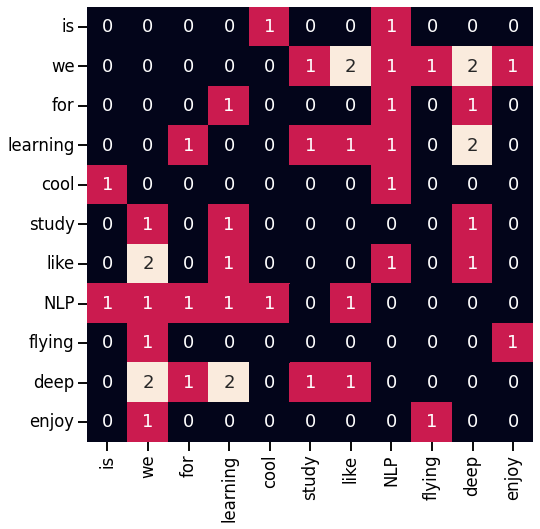

In [ ]:
plt.figure(figsize=(8, 8))
sns.heatmap(cooccurence_matrix, annot=True, cbar = False, xticklabels = vocab, yticklabels = vocab)

### Word-Document Matrix
Based on the conjecture that related words will often appear in the same documents, another type of word counts matrix we can build is 
**a word-document matrix**, $X \in \mathbf{R}^{|V|×M}$, where 
$M$ denotes the number of documents and $|V|$ denotes the number words in the vocabulary. Each time word i appears in document j, we add one to entry $X_{i,j}$. 

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
# specific preprocessing choices can be specified by using different arguments.
# word level analysis is the default setting. 
vectorizer = CountVectorizer() 
# learn the vocabulary dictionary and return document-term matrix.
term_frequencies = vectorizer.fit_transform(corpus) 

# the vocabulary
vocab = vectorizer.get_feature_names_out()
vocab

array(['cool', 'deep', 'enjoy', 'flying', 'for', 'is', 'learning', 'like',
       'nlp', 'study', 'we'], dtype=object)

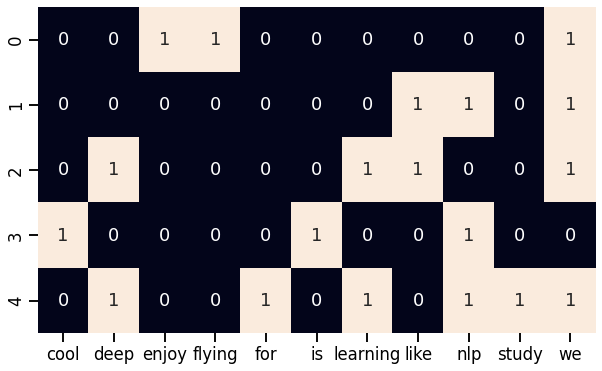

In [ ]:
# the document-term matrix 
term_frequencies_array = term_frequencies.toarray() # convert sparse matrix to numpy array 

plt.figure(figsize=(10, 6))
sns.heatmap(term_frequencies_array, annot=True, cbar = False, xticklabels = vocab);

#### TF-IDF encoding

With a large corpus of documents some words like ‘a’, ‘the’, ‘is’, etc. occur very frequently but they don’t carry a lot of information. Using the above count-based word-document matrix we can decide that these words are important because they appear in many documents. One of the ways to solve this problem is stopwords filtering, but this solution is discrete and not flexible.

**TF-IDF (term frequency - inverse document frequency)** can deal with this problem better. TF-IDF lowers the weight of commonly used words and raises the weight of rare words that occur only in current document. TF-IDF formula looks like this:
<br><br>

$$\text{tf-idf}(term, document)= \text{tf}(term, document) \cdot \text{idf}(term)$$

<br>
Where tf is calculated by dividing number of times the word occurs in the document ($n_i$) by the total number of words in the document ($\sum_{k=1}^W n_k$)

$$\text{tf}(term, document)= \frac{n_i}{\sum_{k=1}^W n_k}$$

IDF (inverse document frequency) can be interpreted like inversed number of documents, in which the term we’re interested in occurs:


$$\text{idf}(term) = \log {\frac{N}{n_t}} $$
where M is the number of documents, $n(t)$ is number of documents with current word t.

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vectorizer = TfidfVectorizer()
tfidf = tfidf_vectorizer.fit_transform(corpus).toarray()

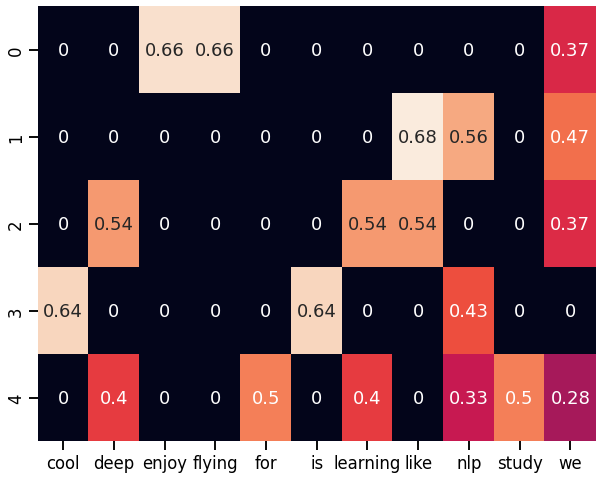

In [ ]:
plt.figure(figsize=(10, 8))
sns.heatmap(tfidf, annot=True, cbar = False, xticklabels = vocab)

## Matrix factorization via PCA

### Prerequisite statements and theory

Principal component analysis (PCA) is a multivariate technique that analyzes a data table in which observations are described by several inter-correlated quantitative dependent variables. It is used to reduce the dimensionality of the data, increasing interpretability but at the same time minimizing information loss. It does so by creating new uncorrelated variables that successively maximize variance.

PCA finds eigen vectors of covariance matrix of centered data, which equal to principal directions / axes when we select K << D vectors which **corresponds** to the K largest eigen values.

$$V \Sigma V^\top = X^\top X , \; X \in R^{N,D}, \Sigma, V \in R^{D,D}$$

The important part here is that we must center data matrix here in order to compute the covariance $X^\top X$. 

Clearly after PCA we do not get principal components yet, we get the principal axes on which we project original data and obtain the compressed data matrix:

$$ Z =  \hat{V}^\top X,$$
where $\hat{V} \in R^{D,K}$ i.e. we select top K columns, because **they correspond to top k eigen values!** 
 

### Realizing PCA using Singular Value Decomposition (SVD)
The Singular Value Decomposition (SVD) algorithm factorizes a matrix into one matrix with **orthogonal columns** and one with **orthogonal rows** (along with a diagonal matrix, which contains the **relative importance** of each factor).

SVD is an **exact decomposition**, since the matrices it creates are big enough to fully cover the original matrix. SVD is extremely widely used in linear algebra, and specifically in data science. If you want to learn SVD from basic linear algebra, please check out this [document](https://davetang.org/file/Singular_Value_Decomposition_Tutorial.pdf). When it comes to large corpora, we extract the top $k$ vector components for a relatively small $k$, and this algorithm is refered to as `Truncated SVD`. SciPy or scikit-learn provide pre-programmed implementations of it. 

With SVD we skip the step of computing covariance in PCA. It is a nice implementation trick, *but* we must do data centering to achieve principal components. 



$$X = U S V^\top$$

$$C = X^\top X =  VSU^\top USV^\top=V S S  V^\top,$$

**as we see V as right singular vectors of data matrix equals to eigen vectors of the covariance matrix of the same data!!**

So now we can use $V$ in the same way as with PCA before (as principal axes or dictionary). But there is nice outcome with SVD is that $U S$ (not $U$ alone) is principal components or lower dimensional data once we clip top K values / columns.


#### Implementation twists 

Some SVD functions DO NOT enforce decreasing ordering of singular values / vectors which basically may break the algo: 
https://docs.scipy.org/doc/scipy/reference/generated/scipy.sparse.linalg.svds.html
check this line there: **The order of the singular values is not guaranteed.**

On the other hand, in different place of the lab we used https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.TruncatedSVD.html which is the part of decomposition package and it takes care about the ordering. I think this is really important for students to understand and at the moment it is not clear in the layout imo.

### how this works in reality with sklearn of TruncatedSVD

if we check this
https://github.com/scikit-learn/scikit-learn/blob/0d378913b/sklearn/decomposition/_truncated_svd.py#L218-L225

we see that it goes 'safe' path by projecting the original data on right sing vectors if randomized or other approximations were used *and* it goes with $U S$ way otherwise. But it never just uses $U$ itself.


## Topic modeling
In natural language understanding tasks, there is a hierarchy of lenses through which we can extract meaning — from words to sentences to paragraphs to documents. 

At the document level, besides using these explicit building units, one can understand text is by analyzing its *topics*. The process of learning, recognizing, and extracting these topics across a collection of documents is called **topic modeling**.

Topic models are built around the idea that the semantics of our document are actually being governed by some hidden, or **“latent,”** variables that we are not observing. As a result, the goal of topic modeling is to uncover these latent variables — topics — that shape the meaning of our document and corpus. 


#### Latent Semantic Analysis (LSA)
Latent Semantic Analysis (LSA) is used to find the hidden topics represented by the document or text. This hidden topics then are used for clustering the similar documents together. LSA is an unsupervised algorithm and hence we don’t know the actual topic of the document. 

We modify the above figure about matrix factorization for word embeddings to illustrate the operations behind LSA:

<div>
<img src="https://drive.google.com/uc?export=view&id=1yOyV-PNO9rV_rVUusbvkYFtlJClrUyvJ" width="600"/>
</div>

While in the previous approaches the word-document matrix served only to get word vectors in $V$, here we are also interested in the other matrix $U$, referred to as, document by topic vectors. 




In [ ]:
# Sentences sampled from https://github.com/townie/PTB-dataset-from-Tomas-Mikolov-s-webpage/raw/master/data/ptb.train.txt 
corpus = [
          "the percentage of lung cancer deaths among the workers at the west mass.",
          "paper factory appears to be the highest for any asbestos workers studied in western industrialized countries he said", 
          "the finding probably will support those who argue that the u.s. should regulate the class of asbestos",
          "the u.s. is one of the few industrialized nations that does n't have a higher standard of regulation for the smooth fiber",
          "in july the environmental protection agency imposed a gradual ban on virtually all uses of asbestos",
          "typically money-fund yields beat comparable short-term investments because portfolio managers can vary maturities and go after the highest rates",
          "the federal government suspended sales of u.s. savings bonds because congress has n't lifted the ceiling on government debt ",
]

In [ ]:
from sklearn import decomposition

X = tfidf_vectorizer.fit_transform(corpus)

svd_model = decomposition.TruncatedSVD(n_components=5, algorithm='randomized', n_iter=100, random_state=122)
lsa = svd_model.fit_transform(X)
lsa.shape

(7, 5)

In [ ]:
lsa

array([[ 0.55710642, -0.08836836, -0.12793413, -0.28801755, -0.272064  ],
       [ 0.41176063, -0.00267593,  0.75826752,  0.01224286, -0.38265911],
       [ 0.581758  , -0.18070164, -0.17899469, -0.18876849,  0.51855871],
       [ 0.60587514, -0.17186525, -0.03152019, -0.28976173,  0.01778295],
       [ 0.41114131, -0.09688872,  0.18978101,  0.76531813,  0.32355168],
       [ 0.19096307,  0.91115605,  0.15077183, -0.16682268,  0.26476274],
       [ 0.4118591 ,  0.30453066, -0.54519025,  0.38361512, -0.4538026 ]])

#### Latent Dirichlet allocation (LDA)

LDA was applied in machine learning by David Blei, Andrew Ng and Michael I. Jordan in 2003 (https://www.jmlr.org/papers/volume3/blei03a/blei03a.pdf) for document modeling, text classification,
and collaborative filtering. It has became the most popular (and typically most effective) topic modeling technique out there. 

LDA is a three-level hierarchical Bayesian model, in which each item of a collection is modeled as a finite mixture over an underlying set of topics. Each topic is, in turn, modeled as an infinite mixture over an underlying set of topic probabilities.  

A graphical model representation of LDA: 
<div>
<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/4/4d/Smoothed_LDA.png/251px-Smoothed_LDA.png" width="400"/>
</div>

M denotes the number of documents

N is number of words in a given document (document i has $N_{i}$ words)

$\alpha$ is the parameter of the Dirichlet prior on the per-document topic distributions

$\beta$ is the parameter of the Dirichlet prior on the per-topic word distribution

$\theta _{i}$ is the topic distribution for document i

$\varphi _{k} $is the word distribution for topic k

$z_{ij}$ is the topic for the j-th word in document i

$w_{ij}$ is the specific word.

Given a corpus $D$, we can obtain the probability of it under the LDA model, 
<div>
<img src="https://drive.google.com/uc?export=view&id=1OgH53_v568g8YUjX_lrBRqjVT-WvOKtc" width="440"/>
</div>

In the paper from Blei et.al., they propose to use a variational Bayes approximation of the posterior distribution for LDA. Practically, we can use the implementation in Gensim to apply LDA for topic modeling: https://radimrehurek.com/gensim/models/ldamodel.html
 



In [ ]:
! pip install gensim

In [ ]:
# from gensim.test.utils import common_texts
from gensim.corpora.dictionary import Dictionary
from gensim.models import LdaModel

# Create a corpus from a list of texts
texts = [doc.split(' ') for doc in corpus]
common_dictionary = Dictionary(texts)
common_corpus = [common_dictionary.doc2bow(text) for text in texts]

# Train the model on the corpus.
lda = LdaModel(common_corpus, num_topics=5)

In [ ]:
# topic-term matrix: \phi_1, ..., \phi_k
lda.get_topics().shape

(5, 92)

In [ ]:
# topic document matrix: \theta
[lda[common_dictionary.doc2bow(text)] for text in texts]

[[(0, 0.014313581),
  (1, 0.014308051),
  (2, 0.014325354),
  (3, 0.0143714575),
  (4, 0.9426816)],
 [(0, 0.010539226),
  (1, 0.010563652),
  (2, 0.010535389),
  (3, 0.0105713345),
  (4, 0.9577904)],
 [(0, 0.011209148),
  (1, 0.011129644),
  (2, 0.011159586),
  (3, 0.9552429),
  (4, 0.011258719)],
 [(4, 0.9650773)],
 [(0, 0.011789601),
  (1, 0.011842419),
  (2, 0.011822174),
  (3, 0.06952684),
  (4, 0.89501905)],
 [(0, 0.010017078),
  (1, 0.9598166),
  (2, 0.010033239),
  (3, 0.010048731),
  (4, 0.010084426)],
 [(2, 0.9615207)]]

## Word2Vec: a neural based word-embedding algorithm 

Word2vec is one of the most popular prediction-based work embedding techninque using a shallow neural network.  The  word embeddings are part of the network's parameters. 

We demonstrate a common implementation of it, Skip-gram with Negative Sampling (SGNS). Suppose that you have a sliding window of a fixed size $m$, moving along a sentence: the word in the middle is the `center word`, denoted by $w_c$, and those on its left and right within the sliding window are the `context words`, denoted by $w_o$. The task of the Skip-gram model is to predict the context words for a given center word. 

Given the vocabulary size $V$, we are about to learn word embedding vectors of size $N$. The word embedding matrix $W$
 of size $V\times N$ gives us the embedding vector of the input word $v_i$: the i-th row of the matrix $W$.  The word context matrix $W'$ of size $N\times V$ produces the output one-hot encoded vector for the context word. The output context matrix $W'$ encodes the meanings of words as context, different from the embedding matrix $W$.
 
<table><tr>
<td> <img src="https://lena-voita.github.io/resources/lectures/word_emb/w2v/window_two_vocs4-min.png" alt="Lena-voita" width="600;"/> </td>
<td> <img src="https://lh6.googleusercontent.com/AG1tU34mgSlYAM-QVVXYDR7FJjiJ4aO7KTLrDbecyiEtuP8qw9kmHvEzky2nBwPsxsXVCUDFI5vXY7hlqBrQ7cwwLsNCqGbikktMDz4VXDFLT1o5ykGJIRdLOzcBRM4dnQptb5NQ" alt="computation" width="310"/> </td>
</tr></table>

With a given window size $m$,  we compute the average negative log-likelihood over positions in a text corpus to get the objective function: 
$$L_{\theta} = - \frac{1}{T}\sum_{t=1}^{T}\sum_{-m \leq j \leq m} \log p(w_{t+j}| w_t, \theta)$$
where 
$$p(w_o | w_c, \theta) = \frac{\exp(u^T_{w_o} v_{w_c})}{\sum_{w \in V} \exp(u^T_w v_{w_c})}
$$
Thus the loss term for each pair of center and context word is:
$$l_{\theta}(w_c, w_o) = - \log \frac{\exp(u^T_{w_o} v_{w_c})}{\sum_{w \in V} \exp(u^T_w v_{w_c})}  $$

**Negative sampling for faster training**

<div>
<img src="https://lena-voita.github.io/resources/lectures/word_emb/w2v/negative_sampling-min.png" width="700"/>
</div>


Original papers on Word2vec:

[1] Tomas Mikolov, Kai Chen, Greg Corrado, and Jeffrey Dean. Efficient Estimation of Word Representations in Vector Space. In Proceedings of Workshop at ICLR, 2013.

[2] Tomas Mikolov, Ilya Sutskever, Kai Chen, Greg Corrado, and Jeffrey Dean. Distributed Representations of Words and Phrases and their Compositionality. In Proceedings of NIPS, 2013.

[3] Tomas Mikolov, Wen-tau Yih, and Geoffrey Zweig. Linguistic Regularities in Continuous Space Word Representations. In Proceedings of NAACL HLT, 2013.



Google published pre-trained vectors trained on part of Google News dataset (about 100 billion words) using word2vec model. The model contains 300-dimensional vectors for 3 million words and phrases. We can download the vectors and analyze it with Gensim. 

In [ ]:
# Download Google Word2Vec embeddings https://code.google.com/archive/p/word2vec/
!wget https://s3.amazonaws.com/dl4j-distribution/GoogleNews-vectors-negative300.bin.gz
!gunzip GoogleNews-vectors-negative300.bin

--2021-11-02 17:38:09--  https://s3.amazonaws.com/dl4j-distribution/GoogleNews-vectors-negative300.bin.gz
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.216.136.190
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.216.136.190|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1647046227 (1.5G) [application/x-gzip]
Saving to: ‘GoogleNews-vectors-negative300.bin.gz’

GoogleNews-vectors- 100%[===================>]   1.53G  45.0MB/s    in 36s     

2021-11-02 17:38:46 (43.6 MB/s) - ‘GoogleNews-vectors-negative300.bin.gz’ saved [1647046227/1647046227]



In [ ]:
# Try Word2Vec with Gensim
import gensim

# Load pretrained vectors from Google
model = gensim.models.KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True)

In [ ]:
king = model['king']
print(king.shape)
print(king[:10])

(300,)
[ 0.12597656  0.02978516  0.00860596  0.13964844 -0.02563477 -0.03613281
  0.11181641 -0.19824219  0.05126953  0.36328125]


In [ ]:
# king - man + woman = queen
print(model.most_similar(positive=['woman', 'king'], negative=['man'])[:3])

[('queen', 0.7118192911148071), ('monarch', 0.6189674139022827), ('princess', 0.5902431011199951)]


In [ ]:
print(model.similarity('woman', 'man'))
print(model.similarity('king', 'woman'))
print(model.similarity('woman', 'queen'))

0.76640123
0.12847973
0.31618136


### SGNS as Implicit Matrix Factorization

[Levy and Goldberg, 2014](https://proceedings.neurips.cc/paper/2014/file/feab05aa91085b7a8012516bc3533958-Paper.pdf) has shown that 
skip-gram with negative-sampling (SGNS) is a implicitly approximation of the factorization of the pointwise mutual information (PMI) of the respective word and context pairs matrix.

PMI(w, c) measures the association between a word $w$ and a context $c$ by calculating the log of the ratio between their joint probability (the frequency in which they occur together) and their marginal probabilities (the frequency in which they occur independently). 

PMI can be estimated empirically by considering the actual number of observations in a corpus:

$$
PMI(w, c) = \log \frac{\#(w,c)|D|}{\#(w) \#(c)}
$$


# Compare matrix factorization against word2vec.
 


### Dataset

In [ ]:
from sklearn.datasets import fetch_20newsgroups
newsgroup_train = fetch_20newsgroups(subset='train')

In [ ]:
import spacy
import string

nlp = spacy.load('en_core_web_sm')
nlp.pipeline=[] # only perform the tokenization step 

punctuations = string.punctuation

# lowercase and remove punctuation
def tokenize(sent):
  tokens = nlp(sent)
  return [token.text.lower() for token in tokens if (token.text not in punctuations)]

def tokenize_dataset(dataset):
    cleaned_dataset = []
    
    for sample in dataset:
        tokens = tokenize(sample)
        cleaned_dataset.append(' '.join(tokens))

    return cleaned_dataset

cleaned_dataset = tokenize_dataset(newsgroup_train.data[:5000])

In [ ]:
del newsgroup_train

### Getting word embeddings by applying SVD on word-document matrix

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vectorizer = TfidfVectorizer(max_df=0.95, min_df=5, max_features=None, stop_words='english')
TFIDF = tfidf_vectorizer.fit_transform(cleaned_dataset)

In [ ]:
vocab = tfidf_vectorizer.get_feature_names_out()

In [ ]:
data = TFIDF.T  # making it N x D

print(data.shape)
# data is not centered
print(data.mean(1))

(15132, 5000)
[[4.25688330e-03]
 [2.82396947e-03]
 [7.83489292e-05]
 ...
 [1.24100904e-04]
 [5.48181262e-04]
 [9.59205983e-05]]


In [ ]:
from sklearn.decomposition import PCA

PCA_model = PCA(n_components=50, svd_solver='arpack').fit(data.todense())
data_compressed = PCA_model.transform(data.todense())

data_compressed.shape

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:590: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:590: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,


(15132, 50)

In [ ]:
mf_embeddings = dict(zip(vocab, data_compressed))

In [ ]:
import numpy as np

# compute cosine similarity between two word vectors 
def cosine_similarity(a, b):
  return np.dot(a, b)/(np.linalg.norm(a)*np.linalg.norm(b))

# gather nearest neighbors based on similarity 
def neighbors_by_similarity(mf_embeddings, word, top):
    v_key = mf_embeddings[word]
    scores = [cosine_similarity(v_key, v) for w, v in mf_embeddings.items() if w!=word]
    indices = np.array([i for i, w in enumerate(mf_embeddings.keys()) if w!=word])
    neighbors = np.argsort(scores)[::-1][:top]
    return indices[neighbors]

In [ ]:
cosine_similarity(mf_embeddings['cat'],  mf_embeddings['dog'])

0.17222974926990725

In [ ]:
[list(tfidf_vectorizer.vocabulary_.keys())[x] for x in neighbors_by_similarity(mf_embeddings, 'women', 10)]

['defenseless',
 'op',
 'played',
 'yz',
 'horn',
 'jpl',
 'hela',
 'readers',
 'insofar',
 'bgu']

### replicating sklearn PCA with SVD from scipy

In [ ]:
from sklearn.utils.extmath import svd_flip

# svd_flip ensures that the output of svd is deterministic is a sense that the largest singlar value is positive

In [ ]:
from scipy import sparse

# centering the data
data_c = data - data.mean(0)

# doing it by hand, svds with centered data lose all benefits of efficient sparse computations ... 
U, s, V = sparse.linalg.svds(data_c, k=50)

s = s[::-1]
# flip eigenvectors' sign to enforce deterministic output
U, V = svd_flip(U[:, ::-1], V[::-1])

In [ ]:
hand_data_compressed = V @ data_c.T

###### Confirm that we get the same results as using implemented PCA in sklearn

In [ ]:
np.linalg.norm(hand_data_compressed.T - data_compressed)  

5.355003827437717e-12

In [ ]:
hand_data_compressed.T[0]

matrix([[ 2.17957892e-01, -1.73368669e-01,  2.71758788e-02,
          8.04996403e-02, -5.34942788e-02, -9.26079056e-02,
          6.58979678e-02, -6.93408650e-02, -6.91576582e-02,
         -1.68397022e-02,  1.38353960e-02,  1.83851365e-01,
         -1.24293447e-01, -9.44332545e-02, -4.64088849e-02,
         -1.87693970e-01, -3.35177279e-01,  3.08891908e-02,
         -4.05447882e-01, -5.96930017e-02,  6.40182125e-02,
         -1.15889152e-01, -1.21373157e-01, -4.31043440e-01,
          2.24184464e-01, -5.88211396e-01, -3.14301456e-01,
          3.26204058e-01,  1.50251210e-01,  2.15285410e-01,
          1.13985144e-01,  3.79849193e-01, -5.02946343e-01,
          8.06524753e-02,  5.44336862e-01,  9.64604673e-02,
          1.33626077e-01, -1.61990872e-01, -4.30419744e-01,
          2.18985507e-01,  1.89610852e-04, -2.04935177e-01,
         -9.80594489e-02,  4.41444248e-02,  1.74300882e-01,
          2.91272490e-01, -4.04165060e-01,  3.40444346e-01,
         -1.90688870e-01,  1.21324034e-0

In [ ]:
data_compressed[0]

array([ 2.17957892e-01, -1.73368669e-01,  2.71758788e-02,  8.04996403e-02,
       -5.34942788e-02, -9.26079056e-02,  6.58979678e-02, -6.93408650e-02,
       -6.91576582e-02, -1.68397022e-02,  1.38353960e-02,  1.83851365e-01,
       -1.24293447e-01, -9.44332545e-02, -4.64088849e-02, -1.87693970e-01,
       -3.35177279e-01,  3.08891908e-02, -4.05447882e-01, -5.96930017e-02,
        6.40182125e-02, -1.15889152e-01, -1.21373157e-01, -4.31043440e-01,
        2.24184464e-01, -5.88211396e-01, -3.14301456e-01,  3.26204058e-01,
        1.50251210e-01,  2.15285410e-01,  1.13985144e-01,  3.79849193e-01,
       -5.02946343e-01,  8.06524753e-02,  5.44336862e-01,  9.64604673e-02,
        1.33626077e-01, -1.61990872e-01, -4.30419744e-01,  2.18985507e-01,
        1.89610852e-04, -2.04935177e-01, -9.80594489e-02,  4.41444248e-02,
        1.74300882e-01,  2.91272490e-01, -4.04165060e-01,  3.40444346e-01,
       -1.90688870e-01,  1.21324034e-02])

In [ ]:
# getting compressed data from U and S

svd_data_compressed = U @ np.diag(s) 

In [ ]:
svd_data_compressed[0]

array([ 2.17957892e-01, -1.73368669e-01,  2.71758788e-02,  8.04996403e-02,
       -5.34942788e-02, -9.26079056e-02,  6.58979678e-02, -6.93408650e-02,
       -6.91576582e-02, -1.68397022e-02,  1.38353960e-02,  1.83851365e-01,
       -1.24293447e-01, -9.44332545e-02, -4.64088849e-02, -1.87693970e-01,
       -3.35177279e-01,  3.08891908e-02, -4.05447882e-01, -5.96930017e-02,
        6.40182125e-02, -1.15889152e-01, -1.21373157e-01, -4.31043440e-01,
        2.24184464e-01, -5.88211396e-01, -3.14301456e-01,  3.26204058e-01,
        1.50251210e-01,  2.15285410e-01,  1.13985144e-01,  3.79849193e-01,
       -5.02946343e-01,  8.06524753e-02,  5.44336862e-01,  9.64604673e-02,
        1.33626077e-01, -1.61990872e-01, -4.30419744e-01,  2.18985507e-01,
        1.89610852e-04, -2.04935177e-01, -9.80594489e-02,  4.41444248e-02,
        1.74300882e-01,  2.91272490e-01, -4.04165060e-01,  3.40444346e-01,
       -1.90688870e-01,  1.21324034e-02])

In [ ]:
# clean up RAM

del svd_data_compressed, hand_data_compressed, U, s, V, data_c

### Getting word embeddings using word co-occurrence matrix

In [ ]:
vocab=list(tfidf_vectorizer.vocabulary_.keys())
vocab_index = dict(zip(vocab, range(len(vocab))))

In [ ]:
data_matrix = get_cooccurrence_matrix(cleaned_dataset, vocab_index, window_size=15)

100%|██████████| 5000/5000 [00:11<00:00, 453.26it/s]


In [ ]:
PCA_model = PCA(n_components=50, svd_solver='arpack').fit(data_matrix)
co_pca_matrix = PCA_model.transform(data_matrix)

co_embeddings = dict(zip(vocab, co_pca_matrix))

In [ ]:
cosine_similarity(co_embeddings['college'],  co_embeddings['school'])

0.8882166061200749

In [ ]:
[list(tfidf_vectorizer.vocabulary_.keys())[x] for x in neighbors_by_similarity(co_embeddings, 'women', 10)]

['children',
 'men',
 'million',
 'killed',
 'population',
 'lived',
 'thousands',
 'thousand',
 'nearly',
 'town']

### Word2vec with fasttext

[FastText](https://github.com/facebookresearch/fastText) is an extension of word2vec. FastText was developed by the team of Tomas Mikolov who proposed the word2vec framework in 2013.

The main improvement of FastText over the original word2vec vectors is the inclusion of character [n-grams](https://en.wikipedia.org/wiki/N-gram), which allows computing word representations for words that did not appear in the training data (“out-of-vocabulary” words).

In [ ]:
!pip install Cython --install-option="--no-cython-compile"
!pip install fasttext

/usr/local/lib/python3.7/dist-packages/pip/_internal/commands/install.py:232: UserWarning: Disabling all use of wheels due to the use of --build-option / --global-option / --install-option.
  cmdoptions.check_install_build_global(options)
     |████████████████████████████████| 68 kB 4.4 MB/s 
  Using cached pybind11-2.8.1-py2.py3-none-any.whl (208 kB)
  Created wheel for fasttext: filename=fasttext-0.9.2-cp37-cp37m-linux_x86_64.whl size=3126170 sha256=e2fda444c05ad96141d2af333ab421f45f9ea2b1bc105f04531ee44a891e4c5b
  Stored in directory: /root/.cache/pip/wheels/4e/ca/bf/b020d2be95f7641801a6597a29c8f4f19e38f9c02a345bab9b
Successfully built fasttext


In [ ]:
with open('newsgroup_train', 'a') as f:
  f.writelines(cleaned_dataset)

In [ ]:
import fasttext
# To make it more comparable with what we obtained using matrix factorization, 
# we do not use subword informations
# --> full list of configurations: https://fasttext.cc/docs/en/python-module.html#train_unsupervised-parameters
model = fasttext.train_unsupervised('newsgroup_train', 
                                    maxn=0,  # word token only
                                    dim=50 # dimension of the word vector
                                    )

In [ ]:
len(model.words)

17793

In [ ]:
# get word embeddings for a given word
model.get_word_vector("university")

array([ 0.37385666, -0.03521482, -0.10790657,  0.40682197, -0.21614093,
        0.02225191, -1.5182861 ,  0.7919668 ,  1.1284701 , -0.19299145,
        0.17825775,  0.901467  ,  0.14084709, -0.8201849 ,  0.44233647,
        0.25164554, -0.2728029 ,  1.2649347 , -0.15134616, -0.39896974,
       -0.99673176,  0.05541895, -0.94515747,  0.2483534 , -0.43995127,
        0.6583506 ,  0.95799077, -0.70909315,  0.13629696,  1.1524901 ,
        0.32315308, -0.47709057, -1.0260085 , -0.81363374,  0.13877961,
       -1.026709  ,  0.8602526 , -0.46637955, -0.7642689 , -1.7687448 ,
       -0.07208803,  0.1036774 , -0.50514597, -0.7917356 ,  0.90038353,
       -1.1709813 ,  0.9462518 ,  0.208496  , -0.9450795 , -0.41948634],
      dtype=float32)

In [ ]:
cosine_similarity(model['college'],  model['school'])

0.691541

In [ ]:
model.get_nearest_neighbors('college')

[(0.8278947472572327, 'university'),
 (0.7888807654380798, 'walla'),
 (0.7857421636581421, 'osteopathic'),
 (0.7738668918609619, 'cwru'),
 (0.7719133496284485, 'hiram'),
 (0.7710863947868347, 'graduate'),
 (0.7690035700798035, 'claremont'),
 (0.765940248966217, 'hanover'),
 (0.7632396221160889, 'allegheny'),
 (0.7619629502296448, 'saratoga')]

In [ ]:
model.get_nearest_neighbors('women')

[(0.8369419574737549, 'children'),
 (0.800446629524231, 'men'),
 (0.7935375571250916, 'girls'),
 (0.7847356796264648, 'wives'),
 (0.7829654216766357, 'elderly'),
 (0.7806590795516968, 'pregnant'),
 (0.777249813079834, 'defenseless'),
 (0.7757340669631958, 'families'),
 (0.7675542235374451, 'fleeing'),
 (0.7620115876197815, 'mothers')]

In [ ]:
cosine_similarity(model['women'],  model['girls'])

0.79353756

## visualization of the word embeddings

In [ ]:
from sklearn.manifold import TSNE 
import matplotlib
import matplotlib.cm as cm  
import numpy as np

def tsne_plot_similar_words(title, labels, embedding_clusters, word_clusters, a, filename=None):
    figsize = (9.5,6) if (matplotlib.get_backend() == 'nbAgg') else (18,10)  # interactive plot should be smaller
    plt.figure(figsize=(figsize))
    colors = cm.rainbow(np.linspace(0, 1, len(labels)))
    for label, embeddings, words, color in zip(labels, embedding_clusters, word_clusters, colors):
        x = embeddings[:, 0]
        y = embeddings[:, 1]
        plt.scatter(x, y, c=[color], alpha=a, label=label)
        for i, word in enumerate(words):
            plt.annotate(word, alpha=0.5, xy=(x[i], y[i]), xytext=(5, 2),
                         textcoords='offset points', ha='right', va='bottom', size=8)
    plt.legend(loc=4)
    plt.title(title)
    plt.grid(True)
    plt.show()

Key = college ['circles', 'ottawa', 'xserver', 'rare', 'manipulating', 'page', 'dumping', 'clay', 'abuses', 'condemn', 'nb', 'chhabra', '77058', 'domains', 'lose', 'contain', 'blinking', 'greenbelt', 'duane', 'moncton', 'ethic', 'barrier', 'web', 'glens', 'cipriani', 'vandalizing', 'ventura', 'pushing', 'schmidt', 'ratios']
Key = russian ['bj', 'tonight', 'finish', 'region', 'dcs', 'sterile', 'veracity', 'bubble', 'copper', 'bake', 'tcd', 'helping', 'devise', '1900', 'weekly', 'allows', 'uuencode', 'robot', 'restricting', '1210', 'judges', 'contacts', 'yawney', '455', 'reusable', '577', 'melb', 'saves', 'atheistic', 'gretzky']
Key = model ['portable', 'heidelberg', 'constitution', 'camp', 'run', 'disgust', 'bus', 'apana', 'wilmington', 'shz', 'scaled', 'certainly', 'clayton', 'hardware', 'gates', 'om4', 'suite', 'hire', 'funky', 'rq', 'transfer', 'larc', 'approach', 'hypocrisy', 'quite', 'bowman', 'team', 'developed', '3v9f0', 'dns1']
Key = internet ['license', 'binding', 'resolutions'

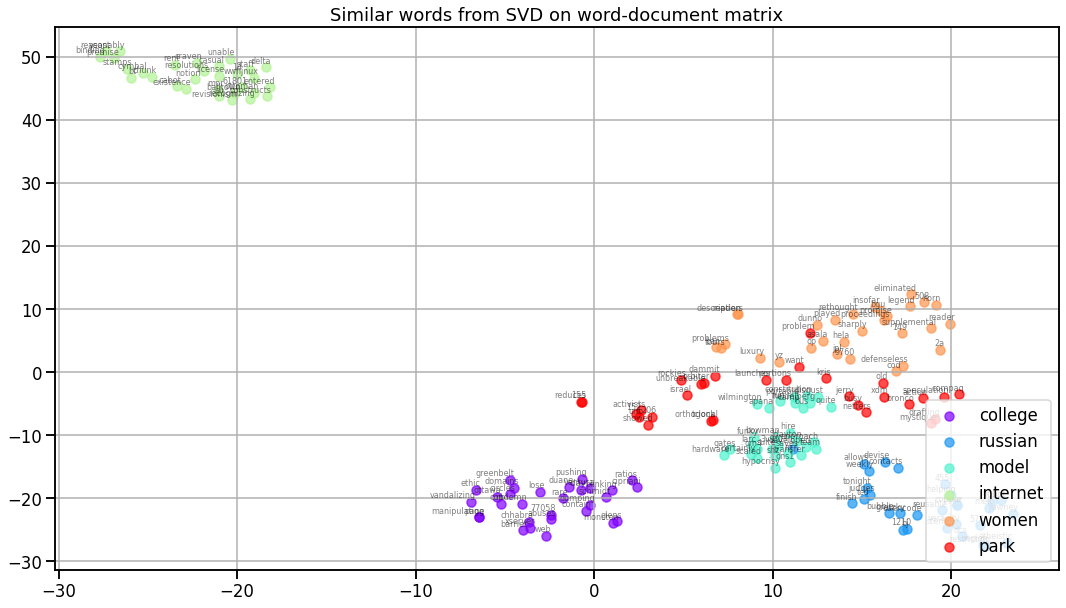

In [ ]:
keys = ['college', 'russian', 'model', 'internet', 'women', 'park']
embedding_clusters = []
word_clusters = []
for word in keys:
    embeddings = []
    words = []
    neighbors = neighbors_by_similarity(mf_embeddings, word, 30)
    for index in neighbors:
        w, v = list(mf_embeddings.items())[index]
        words.append(w)
        embeddings.append(v)
    embedding_clusters.append(embeddings)
    word_clusters.append(words)
    print(f"Key = {word}", words)

embedding_clusters = np.array(embedding_clusters)
n, m, k = embedding_clusters.shape
tsne_model_en_2d = TSNE(perplexity=15, n_components=2, init='pca', n_iter=3500, random_state=32, n_jobs=-1)
embeddings_en_2d = np.array(tsne_model_en_2d.fit_transform(embedding_clusters.reshape(n * m, k))).reshape(n, m, 2)

tsne_plot_similar_words('Similar words from SVD on word-document matrix', keys, embeddings_en_2d, word_clusters, 0.7,
                        'similar_words_svd.png')

Key = college ['28', '37', '26', '13', '18', '35', '38', '17', '25', '19', '27', '23', '43', '14', 'university', '21', '29', 'division', 'austin', '34', '31', '22', 'hello', '55', '48', 'hi', '12', '54', '33', 'tx']
Key = russian ['demand', 'army', 'government', 'soviet', 'today', 'armenian', 'longer', 'entire', 'russia', 'population', 'turkish', 'german', 'organizations', 'turkey', 'million', 'military', 'aid', 'european', 'armenia', 'officials', 'planned', 'armenians', 'turks', 'historical', 'foreign', 'nazi', 'azerbaijan', 'century', 'genocide', 'victims']
Key = model ['high', 'low', 'price', 'performance', 'sold', 'models', 'quality', 'included', '100', 'condition', 'offer', 'manual', 'add', 'range', 'engine', 'current', 'buy', 'ground', 'speed', 'used', 'nice', 'based', 'level', '90', 'note', 'store', 'easily', 'deal', 'built', 'works']
Key = internet ['privacy', 'email', 'usenet', 'networks', 'electronic', 'related', 'addresses', 'references', 'site', 'academic', 'identity', 'iss

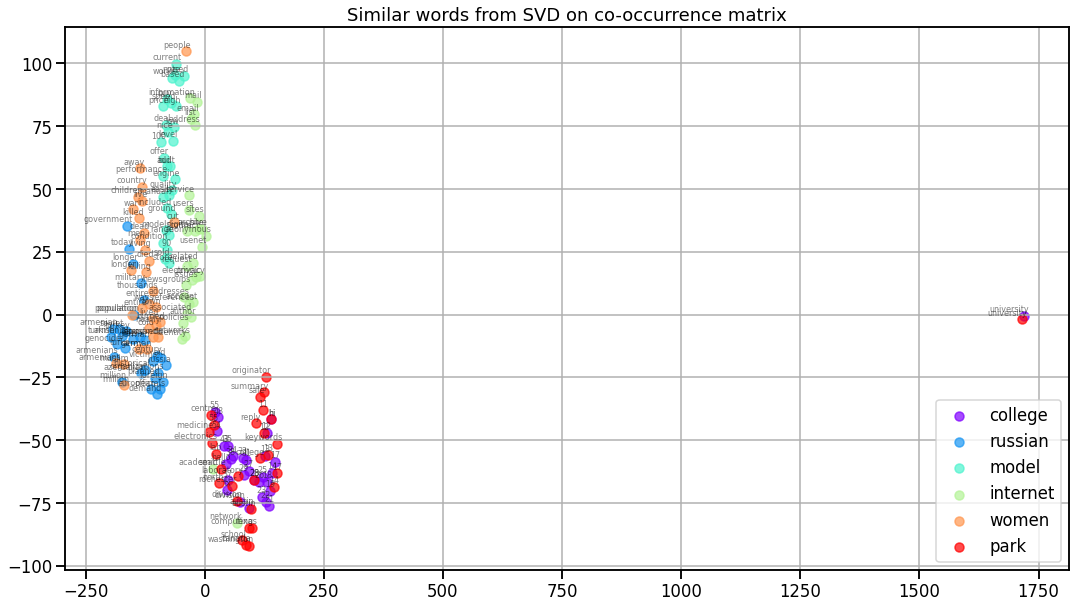

In [ ]:
keys = ['college', 'russian', 'model', 'internet', 'women', 'park']
embedding_clusters = []
word_clusters = []
for word in keys:
    embeddings = []
    words = []
    for index in neighbors_by_similarity(co_embeddings, word, 30):
        w, v = list(co_embeddings.items())[index]
        words.append(w)
        embeddings.append(v)
    embedding_clusters.append(embeddings)
    word_clusters.append(words)
    print(f"Key = {word}", words)

embedding_clusters = np.array(embedding_clusters)
n, m, k = embedding_clusters.shape
tsne_model_en_2d = TSNE(perplexity=15, n_components=2, init='pca', n_iter=3500, random_state=32, n_jobs=-1)
embeddings_en_2d = np.array(tsne_model_en_2d.fit_transform(embedding_clusters.reshape(n * m, k))).reshape(n, m, 2)

tsne_plot_similar_words('Similar words from SVD on co-occurrence matrix', keys, embeddings_en_2d, word_clusters, 0.7,
                        'similar_words_co.png')

Key = college ['university', 'walla', 'osteopathic', 'cwru', 'hiram', 'graduate', 'claremont', 'hanover', 'allegheny', 'saratoga', 'aberystwyth', 'wisconsin', 'ia', 'osu', 'skidmore', 'alberta', 'mudd', 'pennsylvania', 'cruces', 'michigan', 'dartmouth', 'mellon', 'univ', 'nh', 'northeastern', 'carolina', 'hampshire', 'albuquerque', 'iowa', 'malaspina']
Key = russian ['diplomats', 'anatolia', 'territories', 'battalions', 'liberation', '1942', 'invading', 'museums', 'settlements', 'participated', 'breakup', 'elections', 'dashnaks', 'invasion', 'army', 'advisory', '78th', 'cypriot', 'jewry', 'homes', 'seized', 'wwi', 'iranian', 'revolutionary', 'consisted', 'ssr', 'collaboration', 'officials', 'itar', '1940']
Key = model ['improved', 'camera', 'component', 'cpus', 'ssf', 'proton', 'centaur', 'xa', 'unmanned', 'adcom', 'modular', 'pioneer', 'saturn', 'manned', 'laser', 'laserdisc', 'mopar', 'motor', 'lh', 'detached', 'scanners', 'possiblity', 'motors', 'navigation', 'osc', 'booster', 'gadg

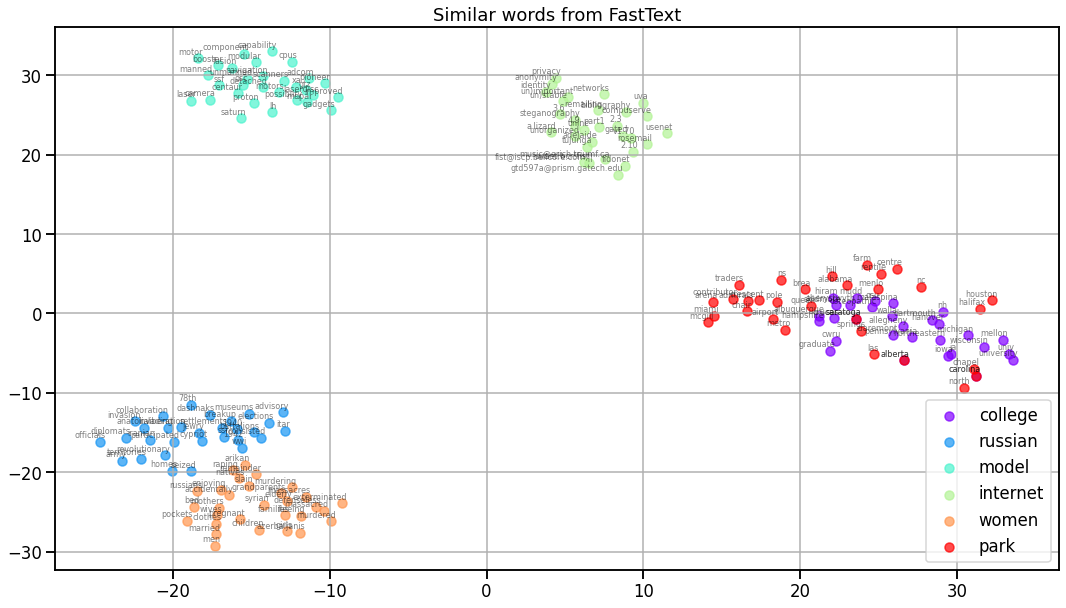

In [ ]:
keys = ['college', 'russian', 'model', 'internet', 'women', 'park']
embedding_clusters = []
word_clusters = []
for word in keys:
    
    embeddings = []
    words = []
    for _, similar_word in model.get_nearest_neighbors(word, 30):
        words.append(similar_word)
        embeddings.append(model[similar_word])
    embedding_clusters.append(embeddings)
    word_clusters.append(words)
    print(f"Key = {word}", words)


embedding_clusters = np.array(embedding_clusters)
n, m, k = embedding_clusters.shape
tsne_model_en_2d = TSNE(perplexity=15, n_components=2, init='pca', n_iter=3500, random_state=32, n_jobs=-1)
embeddings_en_2d = np.array(tsne_model_en_2d.fit_transform(embedding_clusters.reshape(n * m, k))).reshape(n, m, 2)


tsne_plot_similar_words('Similar words from FastText', keys, embeddings_en_2d, word_clusters, 0.7,
                        'similar_words_fasttext.png')

# Some good readings on word embeddings:

* https://lilianweng.github.io/lil-log/2017/10/15/learning-word-embedding.html#other-tips-for-learning-word-embedding 

* https://lena-voita.github.io/nlp_course/word_embeddings.html